<a href="https://colab.research.google.com/github/intel-analytics/analytics-zoo/blob/master/python/orca/colab-notebook/quickstart/ncf_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


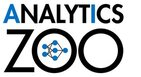
---

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install Analytics Zoo**

You can install the latest release version or latest pre-release version using `pip install --pre --upgrade bigdl-orca`. 

In [ ]:
# Install latest release version of analytics-zoo 
# Installing analytics-zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca[ray]

## **Using Spark Dataframes for Distribtued Deep Learning** 

In this guide we will describe how to use Spark Dataframes to process large-scale dataset.

#### **Intialization** 

import necessary libraries

In [ ]:
import os
import zipfile
import argparse

import numpy as np

from bigdl.dataset import base
from sklearn.model_selection import train_test_split

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext
from bigdl.orca.learn.tf2 import Estimator
from bigdl.orca.data import SharedValue
from pyspark.sql.functions import col
import bigdl.orca.data.pandas

## **Init Orca Context** 

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=1) # run in local mode
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, driver_memory="6g") # run on Hadoop YARN cluster

## **Data Preprocessing with Spark Dataframes**

Orca supports Spark Dataframes as the input to the distributed training, and as the input/output of the distributed inference. Consequently, the user can easily process large-scale dataset using Apache Spark, and directly apply AI models on the distributed (and possibly in-memory) Dataframes without data conversion or serialization.

In [ ]:
# Download and extract movielens 1M data.
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
local_file = base.maybe_download('ml-1m.zip', '.', url)
if not os.path.exists('./ml-1m'):
        zip_ref = zipfile.ZipFile(local_file, 'r')
        zip_ref.extractall('.')
        zip_ref.close()

In [7]:
# Read in the dataset, and do a little preprocessing
rating_files="./ml-1m/ratings.dat"
new_rating_files="./ml-1m/ratings_new.dat"
if not os.path.exists(new_rating_files):
        fin = open(rating_files, "rt")
        fout = open(new_rating_files, "wt")
        for line in fin:
            # replace :: to : for spark 2.4 support
            fout.write(line.replace('::', ':'))
        fin.close()
        fout.close()

In [8]:
# read csv
spark = OrcaContext.get_spark_session()
df = spark.read.csv(new_rating_files, sep=':', header=True, inferSchema=True).toDF(
  "user", "item", "label", "timestamp")

user_set = df.select('user').collect()
item_set = df.select('item').collect()

min_user_id = min(user_set)[0]
max_user_id = max(user_set)[0]
min_item_id = min(item_set)[0]
max_item_id = max(item_set)[0]
print(min_user_id, max_user_id, min_item_id, max_item_id)

1 6040 1 3952


In [9]:
# update label starting from 0
df = df.withColumn('label', df.label-1)

In [10]:
# split to train/test dataset
train_data, test_data = df.randomSplit([0.8, 0.2], 100)

### **Define NCF Model**

In [11]:
def model_creator(config):
    import tensorflow as tf
    from tensorflow import keras
    embedding_size=16
    user = keras.layers.Input(dtype=tf.int32, shape=(None,))
    item = keras.layers.Input(dtype=tf.int32, shape=(None,))
    label = keras.layers.Input(dtype=tf.int32, shape=(None,))

    with tf.name_scope("GMF"):
        user_embed_GMF = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_GMF = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        GMF = keras.layers.Multiply()([user_embed_GMF, item_embed_GMF])

    with tf.name_scope("MLP"):
        user_embed_MLP = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_MLP = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        interaction = tf.concat([user_embed_MLP, item_embed_MLP], axis=-1)
        layer1_MLP = keras.layers.Dense(units=embedding_size * 2, activation='relu')(interaction)
        layer1_MLP = keras.layers.Dropout(rate=0.2)(layer1_MLP)
        layer2_MLP = keras.layers.Dense(units=embedding_size, activation='relu')(layer1_MLP)
        layer2_MLP = keras.layers.Dropout(rate=0.2)(layer2_MLP)
        layer3_MLP = keras.layers.Dense(units=embedding_size // 2, activation='relu')(layer2_MLP)
        layer3_MLP = keras.layers.Dropout(rate=0.2)(layer3_MLP)

    # Concate the two parts together
    with tf.name_scope("concatenation"):
        concatenation = tf.concat([GMF, layer3_MLP], axis=-1)
        outputs = keras.layers.Dense(units=5, activation='softmax')(concatenation)
    
    model = keras.Model(inputs=[user, item], outputs=outputs)
    model.compile(optimizer= "adam",
                  loss= "sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    return model

### **Fit with Orca Estimator**

In [ ]:
batch_size=1280
epochs=2
model_dir='./'

# create an Estimator
est = Estimator.from_keras(model_creator=model_creator, workers_per_node=1)

stats = est.fit(train_data,
                epochs=epochs,
                batch_size=batch_size,
                feature_cols=['user', 'item'],
                label_cols=['label'],
                steps_per_epoch=800000 // batch_size,
                validation_data=test_data,
                validation_steps = 200000 // batch_size)

checkpoint_path = os.path.join(model_dir, "NCF.ckpt")
est.save(checkpoint_path)

In [ ]:
# evaluate with Estimator
stats = est.evaluate(test_data, 
                     feature_cols=['user', 'item'],
                     label_cols=['label'],
                     num_steps=100000 // batch_size)
est.shutdown()
print(stats)

In [ ]:
stop_orca_context()